In [37]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy.stats import kurtosis, skew, pearsonr, variation, iqr, somersd

In [38]:
df = pd.read_excel('dataset.xlsx', nrows=279)
df["SESSO"].replace({'M': 0., 'F': 1.}, inplace=True)
df["TARGET"].replace({2.0: 1.}, inplace=True)
for key in df.keys():
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(",", ""), errors='coerce')

correlations = np.array(df.corrwith(df['TARGET'], method="kendall"))[:-1]
print(f"Correlations with TARGET: \n", df.corrwith(df['TARGET'], method="kendall"))
beta = 0.2
chosen_corrs = correlations > beta
X = df.drop(columns='TARGET').to_numpy(dtype=np.float64)
# X = df[['Eosinofili', 'AST', 'LDH', 'PCR', 'Monociti', 'Linfociti']].to_numpy(dtype=np.float64)
X = X[:, chosen_corrs]
y = df['TARGET'].to_numpy(dtype=np.float64)

Correlations with TARGET:  SESSO        -0.249735
AGE           0.056435
WBC          -0.178520
Piastrine    -0.092355
Neutrofili   -0.100715
Linfociti    -0.213555
Monociti     -0.185434
Eosinofili   -0.215767
Basofili     -0.171577
PCR           0.238826
AST           0.410829
ALT           0.224363
ALP          -0.074779
GGT           0.165086
LDH           0.363080
TARGET        1.000000
dtype: float64


<h3>Data pre-processing</h3>
<h4>Missing values</h4>
<p>
To address data incompleteness, we performed missing data imputation by means of the Multivariate Imputation by Chained Equation (MICE)
</p>

In [39]:
imp = IterativeImputer(max_iter=300, random_state=0)
imp.fit(X)
X = np.round(imp.transform(X), 1)

<h4>Data normalization</h4>
<h5>Min-max scaler</h5>
<p>
We used Min-max scaler in 1st attempt of writing this code. Min-max normalization preserves the relationships among the original data values. The cost of having this bounded range is that we will end up with smaller standard deviations, which can suppress the effect of outliers.
</p>

<h5>Scale unit norm</h5>
<p>
In this method we scale input vectors individually to unit norm (vector length). Three types of norms can be used using nomalize function of sklearn library: {‘l1’, ‘l2’, ‘max’}.
</p>

In [40]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = np.round(scaler.transform(X), 2)

from sklearn.preprocessing import normalize
X = np.round(normalize(X, axis=0, norm='max'), 2)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=104, test_size=0.2)

In [42]:
classes = np.unique(y)
relation = []
for cls in classes:
    relation.append(np.median(X_train[y_train == cls], axis=0))
relation = np.asarray(relation).T

# relation = np.zeros((X_train.shape[1], len(classes)), np.float64)
# for i in range(X_train.shape[1]):
#     for cls in range(len(classes)):
#         relation[i, cls] = pearsonr(X_train[y_train == cls][:, i], X_train[y_train == cls][:, 5])[0]

# relation = relation.clip(min=0)
# scaler = MinMaxScaler()
# scaler.fit(relation)
# relation = np.round(scaler.transform(relation), 2)

print(f"Relation:\n", relation)

Relation:
 [[0.065 0.16 ]
 [0.05  0.08 ]
 [0.08  0.12 ]
 [0.23  0.3  ]]


In [43]:
def maxmin_composition(Q, R):
    if Q.ndim < 2:
        Q = np.atleast_2d(Q)
    if R.ndim < 2:
        r = np.atleast_2d(R).T

    m = Q.shape[0]
    n = R.shape[1]
    T = np.zeros((m, n))
    for i in range(n):
        for j in range(m):
            T[j, i] = (np.fmin(Q[j, :], R[:, i].T)).max()

    return T

results_relation = maxmin_composition(X_test, relation)
print(results_relation)

[[0.23 0.3 ]
 [0.23 0.29]
 [0.23 0.26]
 [0.23 0.25]
 [0.17 0.17]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.23]
 [0.23 0.3 ]
 [0.23 0.24]
 [0.23 0.3 ]
 [0.13 0.13]
 [0.23 0.3 ]
 [0.16 0.16]
 [0.15 0.15]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.29]
 [0.23 0.3 ]
 [0.22 0.22]
 [0.16 0.16]
 [0.2  0.2 ]
 [0.23 0.3 ]
 [0.21 0.21]
 [0.23 0.3 ]
 [0.23 0.28]
 [0.23 0.27]
 [0.22 0.22]
 [0.17 0.17]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.19 0.19]
 [0.23 0.3 ]
 [0.23 0.23]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.17 0.17]
 [0.23 0.25]
 [0.23 0.23]
 [0.12 0.12]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.23 0.25]
 [0.23 0.3 ]
 [0.23 0.3 ]
 [0.19 0.19]
 [0.23 0.28]
 [0.23 0.3 ]
 [0.23 0.27]
 [0.23 0.3 ]
 [0.23 0.3 ]]


In [44]:
def predict(X):
    return np.argmax(X, axis=1)

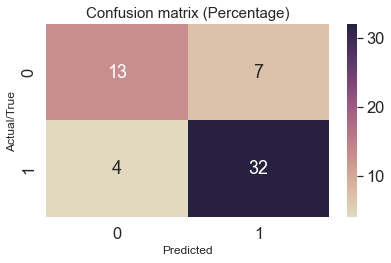

              precision    recall  f1-score   support

     class 0       0.76      0.65      0.70        20
     class 1       0.82      0.89      0.85        36

    accuracy                           0.80        56
   macro avg       0.79      0.77      0.78        56
weighted avg       0.80      0.80      0.80        56



In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_pred = predict(results_relation)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(len(classes)), range(len(classes)))
plt.figure(figsize = (6, 4))
sns.set(font_scale=1.5) # for label size
sns.heatmap(df_cm, annot=True, fmt='d', cmap=sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))
plt.title('Confusion matrix (Percentage)', fontsize = 15)
plt.xlabel('Predicted', fontsize = 12)
plt.ylabel('Actual/True', fontsize = 12) 
plt.tight_layout()
plt.show()

target_names = [f'class {i}' for i in range(len(classes))]
print(classification_report(y_test, y_pred, target_names=target_names))